In [1]:
import os, sys
sys.path.append("..")

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision.utils import make_grid

from src.model import Glow
from src.train import calc_z_shapes

import gc

from src.latent_langevin_dynamics import (
    tensor_list_to_vector, vector_to_tensor_list, sample_z_list, z_list_to_image, latent_langevien_step
)

In [2]:
gc.collect(); torch.cuda.empty_cache()

In [3]:
def unnormalalized_guassian_pdf(x, y, eps):
    return -1/(2*eps)*((y - x).square().sum(dim=(1,2,3)))

### Model loading

In [4]:
N_FLOW = 32
N_BLOCK = 4
AFFINE = False
NO_LU = False
IMG_SIZE = 64
N_SAMPLE = 20
GLOW_DEVICE = "cuda:4"
EPS = 100
TEMP = 0.7 # samples from benchmark obtained with this temperature

In [5]:
MODEL_SINGLE = Glow(
    3, N_FLOW, N_BLOCK, affine=AFFINE, conv_lu=not NO_LU
)
MODEL = nn.DataParallel(MODEL_SINGLE)
MODEL = MODEL.to(GLOW_DEVICE)

MODEL.load_state_dict(torch.load("../data/glow_model.pt"))
SHAPES = calc_z_shapes(3, IMG_SIZE, N_FLOW, N_BLOCK)

../src/model.py:102: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  w_s = torch.from_numpy(w_s)


### Latent Langevien Dynamics

In [6]:
z_list = sample_z_list(batch_size=16, z_shapes=SHAPES, device=GLOW_DEVICE)
z_vector = tensor_list_to_vector(z_list)
cond_img = z_list_to_image(MODEL, z_list)

In [7]:
for i in tqdm(range(10)):
    z_vector = latent_langevien_step(z_vector, cond_img, MODEL,
                                     lambda x,y: unnormalalized_guassian_pdf(x,y, eps=EPS),
                                     shapes=SHAPES)
    
new_img = z_list_to_image(MODEL, vector_to_tensor_list(z_vector, SHAPES))

100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


### Condition images plotting

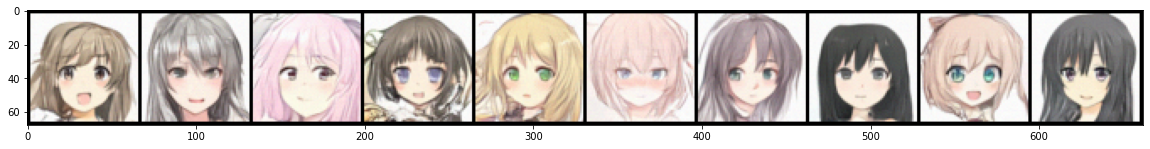

In [8]:
grid = make_grid(
    (cond_img*0.5).cpu().data[:10],
    normalize=True,
    nrow=10,
    range=(-0.5, 0.5),
)

fig, axes = plt.subplots(1, 1, figsize = (20, 4))

axes.imshow(grid.permute(1, 2, 0))
plt.show()

### Sampled image plotting

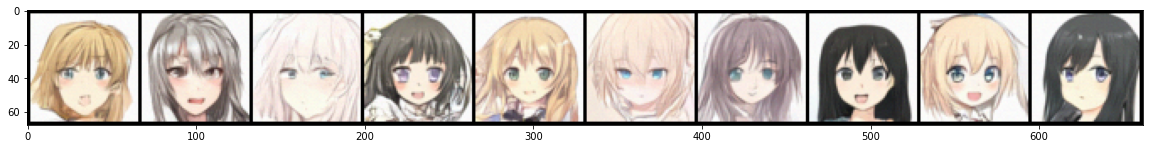

In [9]:
grid = make_grid(
    (new_img*0.5).cpu().data[:10],
    normalize=True,
    nrow=10,
    range=(-0.5, 0.5),
)

fig, axes = plt.subplots(1, 1, figsize = (20, 4))

axes.imshow(grid.permute(1, 2, 0))
plt.show()